In [5]:
import torch
from torch import nn
from torch import distributions as D
from matplotlib import pyplot as plt
import numpy as np

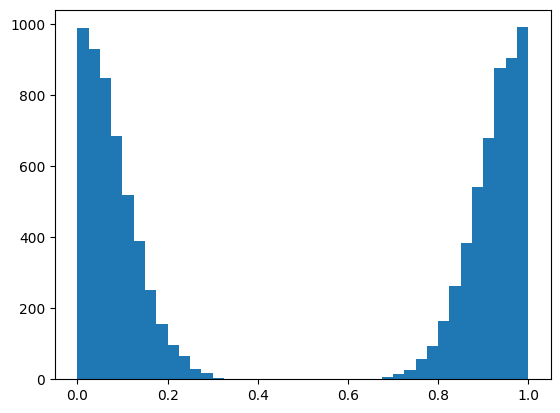

In [2]:
mu = 0

class ShiftedNormal(D.normal.Normal):
    def sample(self, sample_shape=torch.Size()):
        return super().sample(sample_shape) % 1

from lightning_trainable.datasets import DistributionDataset

class ShiftedGaussDataset(DistributionDataset):
    def __init__(self, dimensions: int = 1, **kwargs):
        distribution = ShiftedNormal(mu*torch.ones(dimensions), .1*torch.ones(dimensions))
        super().__init__(distribution, **kwargs)

    
x = ShiftedNormal(mu, .1).sample((10_000,1))
bin_edges = plt.hist(x.detach().numpy(), bins=40)

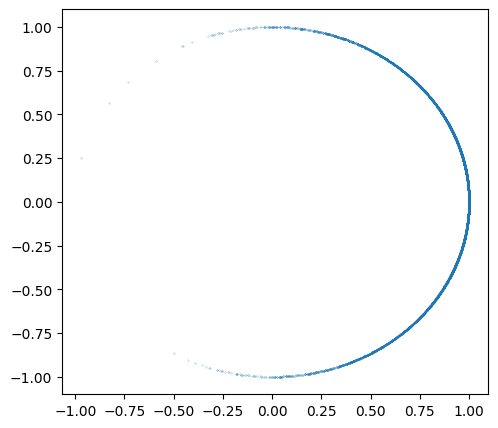

In [17]:
def convert_to_circle(x):
    return torch.cat([torch.cos(2 * np.pi * x), torch.sin(2 * np.pi * x)], dim=-1)

a = convert_to_circle(x)
plt.figure(figsize=(5.5,5))
plt.scatter(a[:,0], a[:,1], marker=".", s=.1)

In [3]:
# calculate theoretical kl
# kl is >=0, but we the kl estimator doesn't include the entropy of the target distribution, so in our case kl_est >= entropy
import scipy
entropy = scipy.stats.norm.entropy(scale=.1)
entropy

-0.8836465597893728

In [4]:
from simplebg.latent import DistributionHParams
from simplebg.loss.core import LossWeights
from simplebg.model.core import ToyHParams, ToyModel
from simplebg.data.loaders import ToyLoader, ToyLoaderHParams

class GaussLoaderHParams(ToyLoaderHParams):
    name = "ShiftedGauss"
    kwargs = {"dimensions": 1}

class GaussLoader(ToyLoader):
    def __init__(self, loader_hparams: ToyLoaderHParams):
        super().__init__(loader_hparams)
        
    def generate_datasets(self):
        # calculate the split sizes
        train_split = int(self.hparams.train_split * self.hparams.samples)
        val_split = int(self.hparams.val_split * self.hparams.samples)
        test_split = self.hparams.samples - train_split - val_split
        # sanity test
        assert (self.hparams.samples * self.hparams.test_split - 2 <= test_split <=
                self.hparams.samples * self.hparams.test_split + 2), \
            "something has gone wrong with the calculation of test_split."

        ToyDataSet = ShiftedGaussDataset
        return (
            ToyDataSet(max_samples=train_split, **self.hparams.kwargs),
            ToyDataSet(max_samples=val_split, **self.hparams.kwargs),
            ToyDataSet(max_samples=test_split, **self.hparams.kwargs)
        )

class MyToyHParams(ToyHParams):
    loader_hparams: GaussLoaderHParams

class MyToyModel(ToyModel):
    loader_class = GaussLoader
    hparams: MyToyHParams

INFO: Using pytorch backend


In [5]:
from simplebg.network.subnets.resnets import ResNetHParams
from simplebg.network.fff import SubNetFlowHParams
from torch.nn import ReLU, SiLU

loader_hparams = GaussLoaderHParams(
    train_split=0.75,
    val_split=0.05,
    test_split=0.2,
    kwargs={"dimensions": 1},
    samples=100_000,
)

resnet_network_hparams = ResNetHParams(
   depth_scheme=[24],
    width_scheme=[64],
    batch_norm=False,
    activation=SiLU(),
)

fff_network_hparams = SubNetFlowHParams(
    subnet_hparams=resnet_network_hparams,
    bottleneck=1,
    transform="identity",
)

hparams = MyToyHParams(
    loader_hparams=loader_hparams,
    network_hparams=fff_network_hparams,    
    latent_hparams=DistributionHParams(
        name="Normal",
        kwargs={"sigma": .1}
    ),
    loss_weights=LossWeights(
        forward_kl=1.,
        reconstruction=10.,
    ),
    max_epochs=50,
    batch_size=1_000,
    lr_scheduler="OneCycleLR",
    optimizer=dict(
        name="Adam",
        lr=1.e-3,
        betas=[.99, .9999],
    ),
    accelerator="auto",
    # gradient_clip=10.,
)

trainer_kwargs = {"fast_dev_run": False, "enable_progress_bar": True}
logger_kwargs = {"name": "ShiftedGauss"}

In [6]:
from simplebg.network.fff import SubNetFlow
SubNetFlow.hparams_type

simplebg.network.fff.SubNetFreeFormFlowHParams

In [7]:
my_model = MyToyModel(hparams)
my_model.fit(trainer_kwargs=trainer_kwargs, logger_kwargs=logger_kwargs)

INFO: Created a temporary directory at /tmp/tmpdk06gbyc
INFO: Writing /tmp/tmpdk06gbyc/_remote_module_non_scriptable.py
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type               | Params
--------------------------------------------
0 | nn   | SubNetFreeFormFlow | 399 K 
--------------------------------------------
399 K     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kortkamp/mambaforge/envs/lightning_bg/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


{'training/loss': -1.011148452758789,
 'training/forward_kl': -1.8919481039047241,
 'training/reconstruction': 0.08807996660470963,
 'validation/loss': 0.7551674246788025,
 'validation/forward_kl': -0.12752674520015717,
 'validation/reconstruction': 0.0882694199681282}

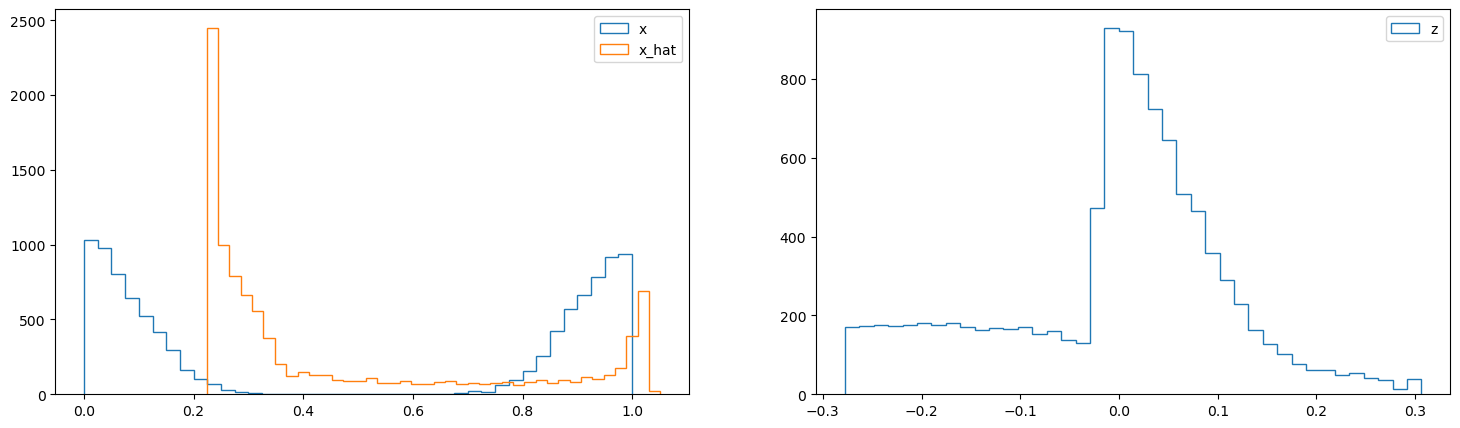

In [8]:
fig, [ax, ax1] = plt.subplots(1, 2, figsize=(18, 5))
x = ShiftedNormal(mu, .1).sample((10_000,1))
ax.hist(x.detach().numpy(), bins=40, label="x", histtype="step")
z = my_model.nn.forward(x).output.squeeze(1)
ax1.hist(z.detach().numpy(), bins=40, label="z", histtype="step")
x_hat = my_model.nn.reverse(z.unsqueeze(-1)).output.squeeze(1)
ax.hist(x_hat.detach().numpy(), bins=40, label="x_hat", histtype="step")
ax.legend()
ax1.legend()

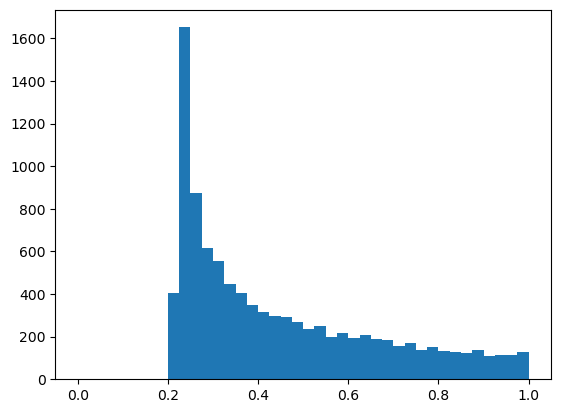

In [9]:
samples = my_model.sample((10_000,)).squeeze(1)
_ = plt.hist(samples, bins=40, range=(0,1))

Text(0.5, 1.0, 'Reconstruction')

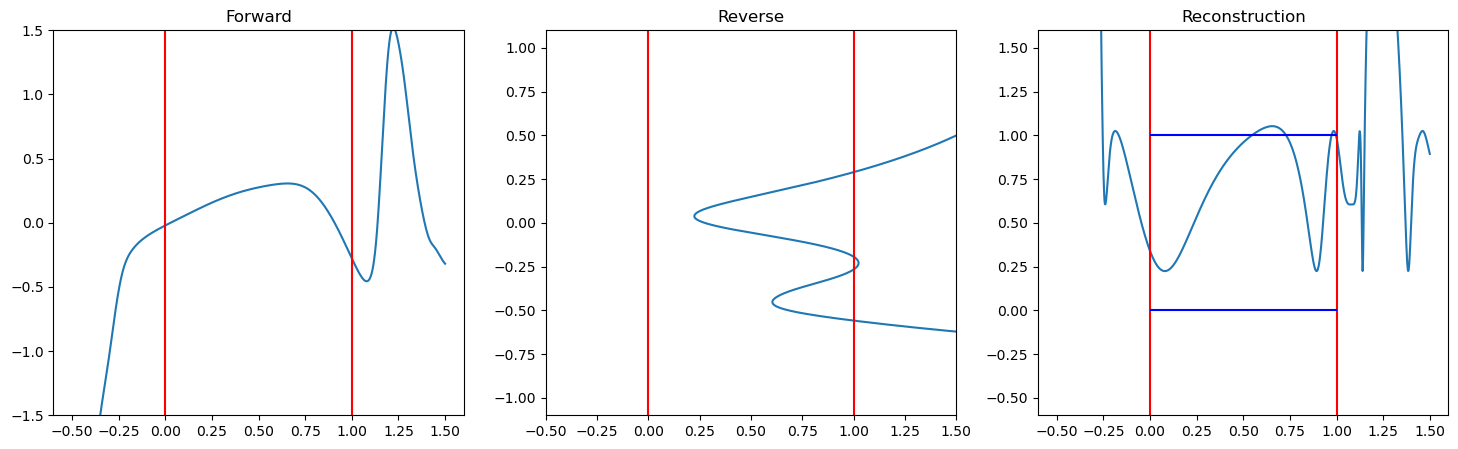

In [12]:
x = torch.linspace(-.5, 1.5, 1000).unsqueeze(1)
z = my_model.nn.forward(x).output.squeeze(1)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(x.detach().numpy(), z.detach().numpy())
ax[0].axvline(0, color='r')
ax[0].axvline(1, color='r')
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title("Forward")
z_rev = torch.linspace(-1, 1, 1000).unsqueeze(1)
x_rev = my_model.nn.reverse(z_rev).output.squeeze(1)
ax[1].plot(x_rev.detach().numpy(), z_rev.detach().numpy())
ax[1].axvline(0, color='r')
ax[1].axvline(1, color='r')
ax[1].set_xlim(-.5, 1.5)
ax[1].set_title("Reverse")
x_hat = my_model.nn.reverse(z.unsqueeze(-1)).output.squeeze(1)
ax[2].plot(x.detach().numpy(), x_hat.detach().numpy())
ax[2].axvline(0, color='r')
ax[2].axvline(1, color='r')
ax[2].hlines(0, 0, 1, color='b')
ax[2].hlines(1, 0, 1, color='b')
ax[2].set_ylim(ax[2].get_xlim())
ax[2].set_title("Reconstruction")

import optuna
def objective(trial):
    lr = trial.suggest_float("lr", 1.e-6, 1.e-2, log=True)
    beta1 = trial.suggest_float("beta1", .9, .999, log=True)
    beta2 = trial.suggest_float("beta2", .99, .9999, log=True)
    optimizer_dict=dict(
        name="Adam",
        lr=1.e-3,
        betas=[.99, .9999],
    )
    hparams.optimizer = optimizer_dict
    my_model = MyToyModel(hparams)
    metrics = my_model.fit(trainer_kwargs=trainer_kwargs, logger_kwargs=logger_kwargs)
    return metrics["validation/loss"]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
study.best_params